
# Heterogenous Independence Work

Some code to read in all the data:

In [1]:
import pathlib
import pandas as pd
import scipy.stats
import numpy as np
import re
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
def read_csv(path):
    """
    Recover parameters from file path and return df
    """
    path = str(path)
    float_regex = re.compile("\d*\.\d+|\d+")
    match = map(float, re.findall(float_regex, path))
    seed, mass_weight, independence_weight, population_seed = match

    distribution_regex = re.compile("homo|normal|pareto")
    match = re.findall(distribution_regex, path)
    mass_distribution, independence_distribution = match

    df = pd.read_csv(path)
    df["seed"] = seed
    df["mass_weight"] = mass_weight
    df["independence_weight"] = independence_weight
    df["population_seed"] = population_seed

    df["total"] = df["defect"] + df["exploit_"] + df["exploit"] + df["coop"]
    df["mutual_cooperation"] = df["coop"] / df["total"]
    df["cooperation"] = (df["exploit_"] + df["exploit"] + 2 * df["coop"]) / (
        2 * df["total"]
    )

    df = df[
        [
            "seed",
            "mass_weight",
            "independence_weight",
            "population_seed",
            "mutual_cooperation",
            "cooperation",
        ]
    ]
    
    df = pd.DataFrame(df.mean()).T
    df["mass_distribution"] = mass_distribution
    df["independence_distribution"] = independence_distribution
    return df

Read in all the data:

In [3]:
data_dir_path = pathlib.Path("./")
data_paths = data_dir_path.glob("./outcomes_per_round/seed*.csv")
df = pd.concat(
    map(read_csv, data_paths),
    ignore_index=True,
)
df["log(mutual_cooperation)"] = np.log(df["mutual_cooperation"])
df["log(cooperation)"] = np.log(df["cooperation"])

In [4]:
df.describe()

,seed,mass_weight,independence_weight,population_seed,mutual_cooperation,cooperation,log(mutual_cooperation),log(cooperation)
count,8025.000000,8025.0,8025.000000,8025.000000,8025.000000,8025.000000,8025.000000,8025.000000
mean,539.880000,1.0,4.859813,536.280000,0.345012,0.528228,-1.113603,-0.657718
std,276.719294,0.0,2.918697,255.561539,0.100856,0.099653,0.330978,0.203078
min,80.000000,1.0,0.000000,35.000000,0.057383,0.201011,-2.858008,-1.604395
25%,367.000000,1.0,2.300000,409.000000,0.271146,0.458434,-1.305098,-0.779940
50%,559.000000,1.0,4.800000,579.000000,0.341573,0.530645,-1.074193,-0.633662
75%,780.000000,1.0,7.400000,721.000000,0.422283,0.605532,-0.862079,-0.501648
max,990.000000,1.0,10.000000,981.000000,0.587981,0.747311,-0.531061,-0.291274


We have 8000+ data points.

If we look at the effect of the mass and independence discributions:

In [5]:
df.groupby(["mass_distribution", "independence_distribution"]).describe()

seed                            \
                                              count    mean         std   min   
mass_distribution independence_distribution                                     
homo              homo                       2675.0  539.88  276.753787  80.0   
normal            homo                       2675.0  539.88  276.753787  80.0   
pareto            homo                       2675.0  539.88  276.753787  80.0   

                                                                         \
                                               25%    50%    75%    max   
mass_distribution independence_distribution                               
homo              homo                       367.0  559.0  780.0  990.0   
normal            homo                       367.0  559.0  780.0  990.0   
pareto            homo                       367.0  559.0  780.0  990.0   

                                            mass_weight       ...  \
                                                  count mean  ...   
mass_distribution independence_distribution                   ...   
homo              homo                           2675.0  1.0  ...   
normal            homo                           2675.0  1.0  ...   
pareto            homo                           2675.0  1.0  ...   

                                            log(mutual_cooperation)            \
                                                                75%       max   
mass_distribution independence_distribution                                     
homo              homo                                    -0.858417 -0.550384   
normal            homo                                    -0.854593 -0.531061   
pareto            homo                                    -0.876239 -0.580001   

                                            log(cooperation)            \
                                                       count      mean   
mass_distribution independence_distribution                              
homo              homo                                2675.0 -0.674477   
normal            homo                                2675.0 -0.648069   
pareto            homo                                2675.0 -0.650607   

                                                                           \
                                                  std       min       25%   
mass_distribution independence_distribution                                 
homo              homo                       0.223048 -1.604395 -0.795785   
normal            homo                       0.202304 -1.595442 -0.781191   
pareto            homo                       0.180694 -1.566319 -0.771675   

                                                                           
                                                  50%       75%       max  
mass_distribution independence_distribution                                
homo              homo                      -0.631583 -0.504997 -0.305932  
normal            homo                      -0.609795 -0.490271 -0.291274  
pareto            homo                      -0.658429 -0.506980 -0.325690  

[3 rows x 64 columns]

Let us graph some of this to get an overview:

/Users/four/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


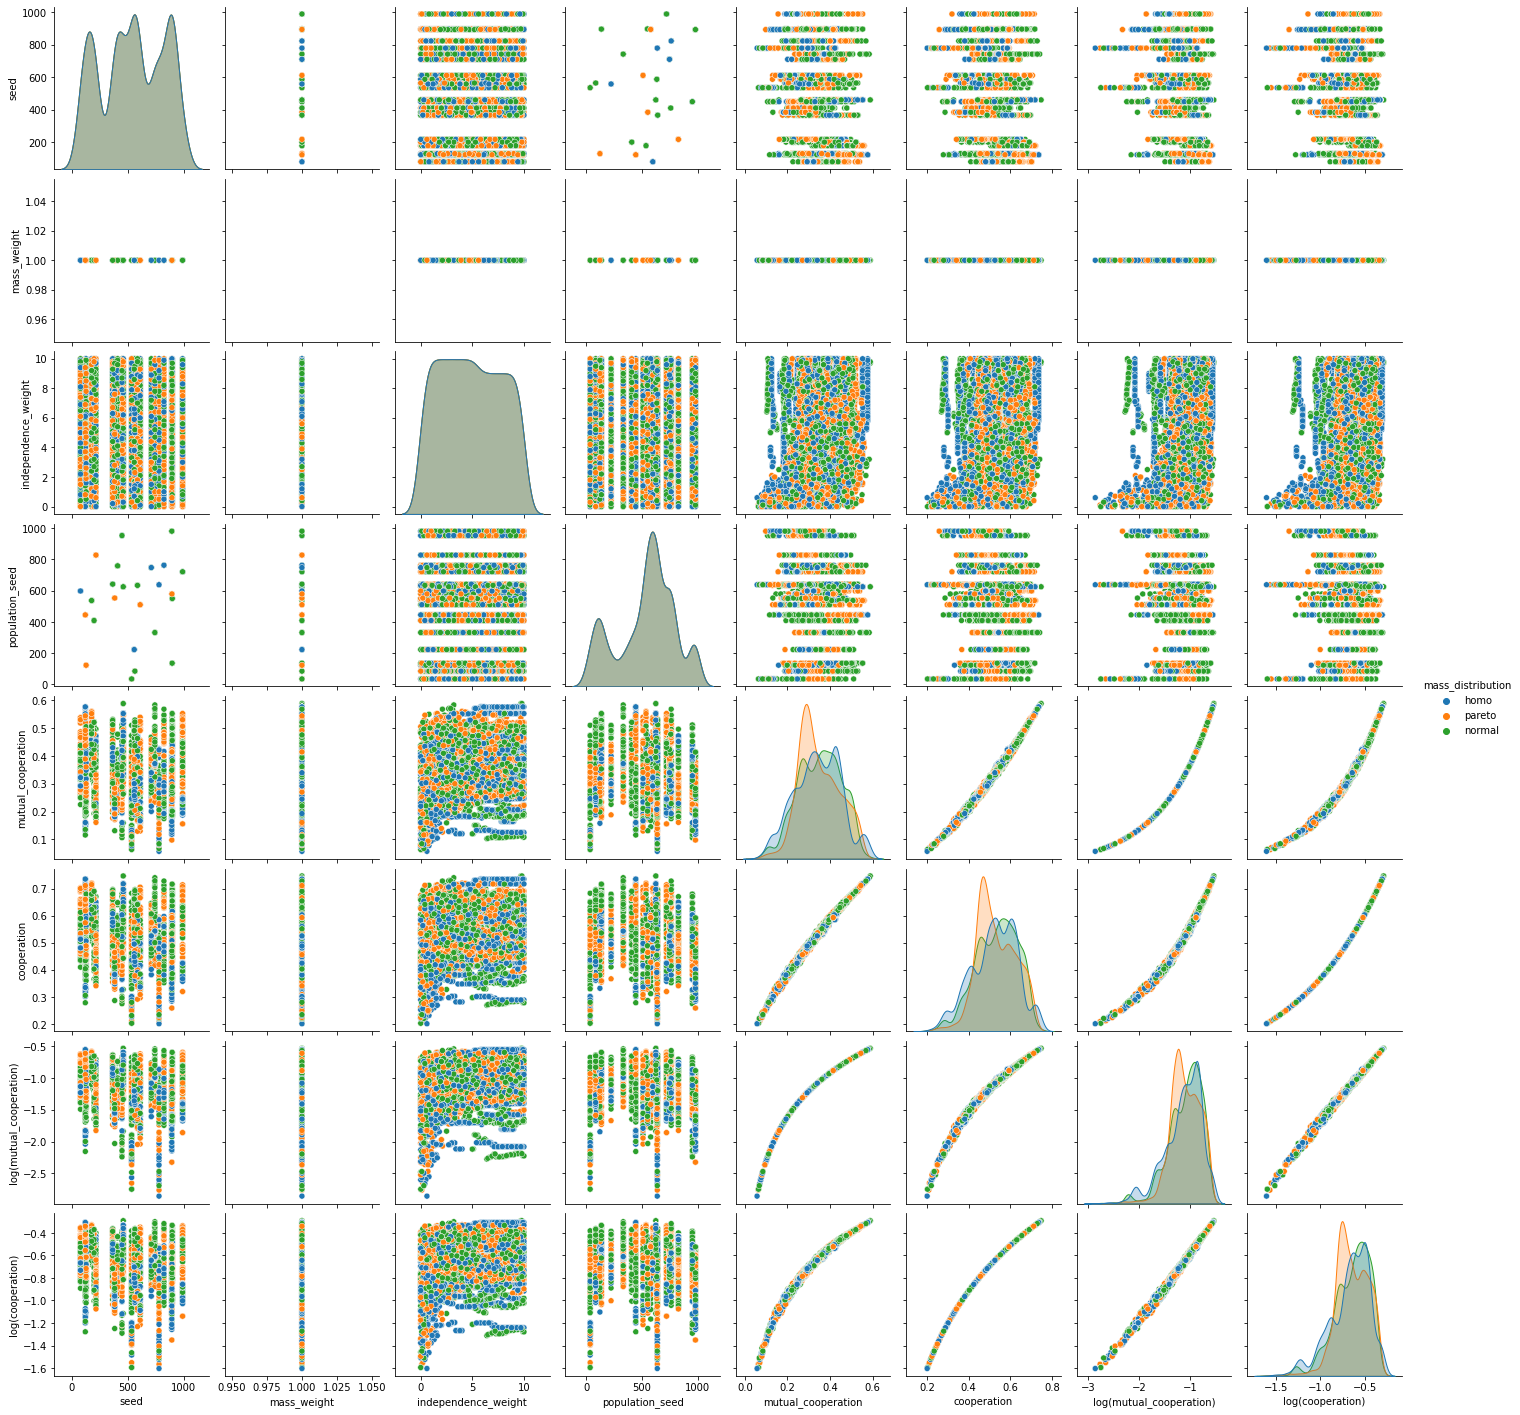

In [6]:
sns.pairplot(data=df, hue="mass_distribution");

## Linear Regression

Let us carry out a linear regression study of mutual cooperation: what effects it?

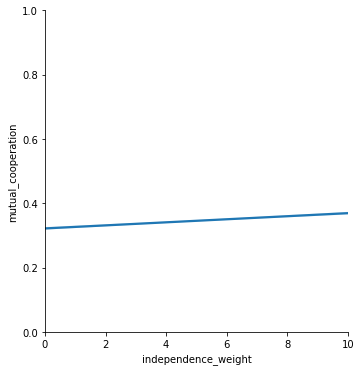

In [7]:
g = sns.lmplot(
    data=df,
    x="independence_weight",
    y="mutual_cooperation",
    fit_reg=True,
    scatter=False,
)
g.set(ylim=(0, 1))

We see that there is some effect of the independence weight on the mutual cooperation rate.

In [8]:
results = smf.ols(
    "mutual_cooperation ~ independence_weight", 
    data=df,
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     mutual_cooperation   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     154.6
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           3.57e-35
Time:                        13:42:51   Log-Likelihood:                 7100.0
No. Observations:                8025   AIC:                        -1.420e+04
Df Residuals:                    8023   BIC:                        -1.418e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3219      0.002    148.613      0.000       0.318       0.326
independence_weight     0.0048      0.000     12.435      0.000       0.004       0.006
==============================================================================
Omnibus:                      169.935   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.289
Skew:                          -0.012   Prob(JB):                     2.48e-20
Kurtosis:                       2.481   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is not a strong model: the effect of independence weight (if significant) is only small, explaining 1.9% of the variance in the data.

Looking at the $p$ value ($P>|t|$) this does show that the effect (although small) is significant.

Let us take a closer look at the effect of the distribution:

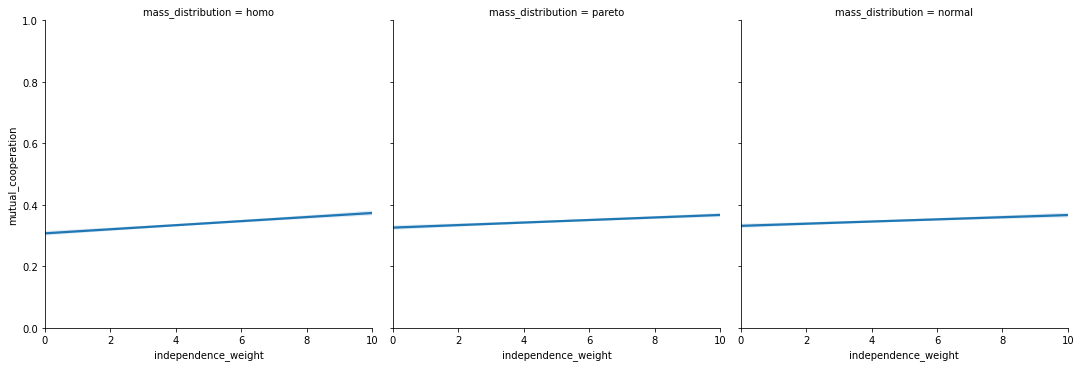

In [9]:
g = sns.lmplot(
    data=df,
    x="independence_weight",
    y="mutual_cooperation",
    col="mass_distribution",
    fit_reg=True,
    scatter=False,
)
g.set(ylim=(0, 1))

The models do not seem to be the same.

In [10]:
df.groupby("mass_distribution").describe()["mutual_cooperation"]

,count,mean,std,min,25%,50%,75%,max
mass_distribution,,,,,,,,
homo,2675.0,0.339771,0.107027,0.057383,0.265584,0.340584,0.423833,0.576728
normal,2675.0,0.349031,0.100174,0.064006,0.269773,0.354401,0.425456,0.587981
pareto,2675.0,0.346234,0.094809,0.063086,0.276462,0.330718,0.416346,0.559898


/Users/four/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/four/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 73.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/four/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 73.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


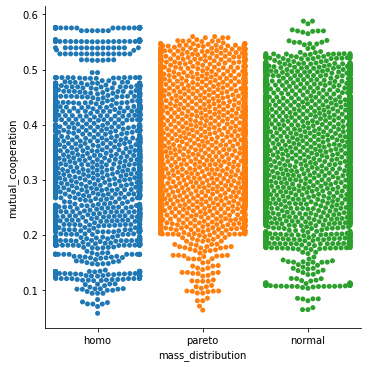

In [11]:
sns.catplot(
    data=df, 
    kind="swarm", 
    x="mass_distribution", 
    y="mutual_cooperation", 
)

What about a log transform of the data:

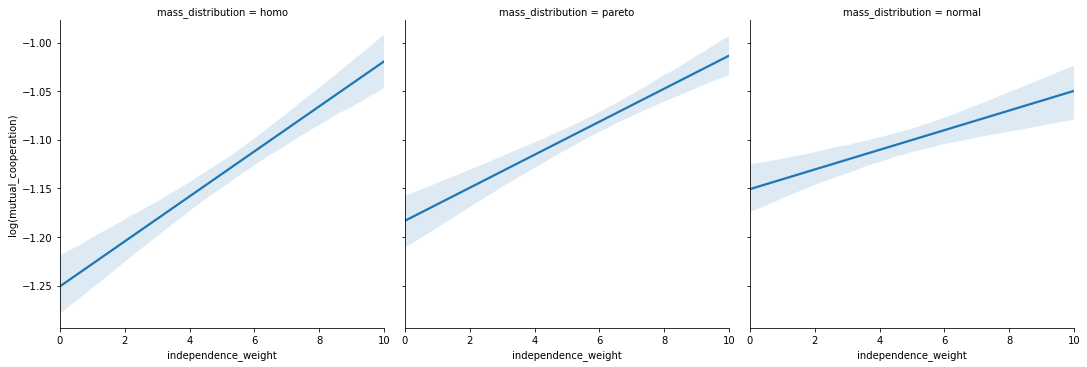

In [12]:
sns.lmplot(
    data=df,
    x="independence_weight",
    y="log(mutual_cooperation)",
    col="mass_distribution",
    fit_reg=True,
    scatter=False,
)

In [13]:
df.groupby("mass_distribution").describe()["log(mutual_cooperation)"]

,count,mean,std,min,25%,50%,75%,max
mass_distribution,,,,,,,,
homo,2675.0,-1.138333,0.363329,-2.858008,-1.325825,-1.077093,-0.858417,-0.550384
normal,2675.0,-1.101679,0.332158,-2.748771,-1.310176,-1.037327,-0.854593,-0.531061
pareto,2675.0,-1.100798,0.292346,-2.763254,-1.285682,-1.106490,-0.876239,-0.580001


/Users/four/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 79.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/four/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 81.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/four/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 79.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


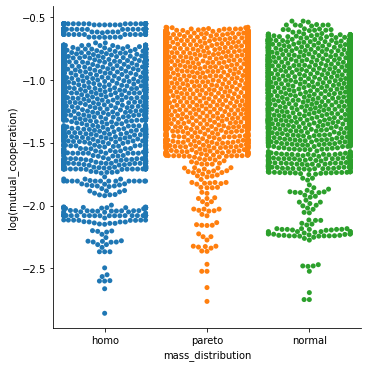

In [14]:
sns.catplot(
    data=df, 
    kind="swarm", 
    x="mass_distribution", 
    y="log(mutual_cooperation)", 
)

Let us create seperate linear models for each distribution:

### Homogeneous:

In [15]:
results = smf.ols(
    "mutual_cooperation ~ independence_weight", 
    data=df[df["mass_distribution"] == "homo"],
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     mutual_cooperation   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     89.95
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           5.19e-21
Time:                        13:43:31   Log-Likelihood:                 2226.9
No. Observations:                2675   AIC:                            -4450.
Df Residuals:                    2673   BIC:                            -4438.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3076      0.004     77.797      0.000       0.300       0.315
independence_weight     0.0066      0.001      9.484      0.000       0.005       0.008
==============================================================================
Omnibus:                       59.778   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.302
Skew:                          -0.054   Prob(JB):                     9.67e-08
Kurtosis:                       2.473   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Log transform of mutual cooperation:

In [16]:
import numpy as np
results = smf.ols(
    "np.log(mutual_cooperation) ~ independence_weight", 
    data=df[df["mass_distribution"] == "homo"],
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(mutual_cooperation)   R-squared:                       0.035
Model:                                    OLS   Adj. R-squared:                  0.034
Method:                         Least Squares   F-statistic:                     95.93
Date:                        Wed, 23 Nov 2022   Prob (F-statistic):           2.81e-22
Time:                                13:43:31   Log-Likelihood:                -1039.7
No. Observations:                        2675   AIC:                             2083.
Df Residuals:                            2673   BIC:                             2095.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.2509      0.013    -93.290      0.000      -1.277      -1.225
independence_weight     0.0232      0.002      9.794      0.000       0.019       0.028
==============================================================================
Omnibus:                      328.321   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              467.076
Skew:                          -0.931   Prob(JB):                    3.76e-102
Kurtosis:                       3.852   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Normal

In [17]:
results = smf.ols(
    "mutual_cooperation ~ independence_weight", 
    data=df[df["mass_distribution"] == "normal"],
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     mutual_cooperation   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     28.34
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           1.10e-07
Time:                        13:43:31   Log-Likelihood:                 2373.7
No. Observations:                2675   AIC:                            -4743.
Df Residuals:                    2673   BIC:                            -4732.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3319      0.004     88.686      0.000       0.325       0.339
independence_weight     0.0035      0.001      5.323      0.000       0.002       0.005
==============================================================================
Omnibus:                       74.516   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.212
Skew:                          -0.217   Prob(JB):                     1.25e-11
Kurtosis:                       2.487   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Log transform of mutual cooperation:

In [18]:
results = smf.ols(
    "np.log(mutual_cooperation) ~ independence_weight", 
    data=df[df["mass_distribution"] == "normal"],
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(mutual_cooperation)   R-squared:                       0.008
Model:                                    OLS   Adj. R-squared:                  0.008
Method:                         Least Squares   F-statistic:                     21.30
Date:                        Wed, 23 Nov 2022   Prob (F-statistic):           4.12e-06
Time:                                13:43:31   Log-Likelihood:                -836.31
No. Observations:                        2675   AIC:                             1677.
Df Residuals:                            2673   BIC:                             1688.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.1508      0.012    -92.607      0.000      -1.175      -1.126
independence_weight     0.0101      0.002      4.615      0.000       0.006       0.014
==============================================================================
Omnibus:                      508.516   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              982.591
Skew:                          -1.146   Prob(JB):                    4.30e-214
Kurtosis:                       4.887   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Pareto

In [19]:
results = smf.ols(
    "mutual_cooperation ~ independence_weight", 
    data=df[df["mass_distribution"] == "pareto"],
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     mutual_cooperation   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     43.81
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           4.37e-11
Time:                        13:43:31   Log-Likelihood:                 2528.6
No. Observations:                2675   AIC:                            -5053.
Df Residuals:                    2673   BIC:                            -5041.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3262      0.004     92.343      0.000       0.319       0.333
independence_weight     0.0041      0.001      6.619      0.000       0.003       0.005
==============================================================================
Omnibus:                      145.017   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.074
Skew:                           0.318   Prob(JB):                     2.76e-20
Kurtosis:                       2.364   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Log transform of mutual cooperation:

In [20]:
results = smf.ols(
    "np.log(mutual_cooperation) ~ independence_weight", 
    data=df[df["mass_distribution"] == "pareto"],
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(mutual_cooperation)   R-squared:                       0.029
Model:                                    OLS   Adj. R-squared:                  0.028
Method:                         Least Squares   F-statistic:                     79.33
Date:                        Wed, 23 Nov 2022   Prob (F-statistic):           9.48e-19
Time:                                13:43:31   Log-Likelihood:                -466.28
No. Observations:                        2675   AIC:                             936.6
Df Residuals:                            2673   BIC:                             948.3
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.1834      0.011   -109.357      0.000      -1.205      -1.162
independence_weight     0.0170      0.002      8.907      0.000       0.013       0.021
==============================================================================
Omnibus:                      184.134   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              295.289
Skew:                          -0.537   Prob(JB):                     7.56e-65
Kurtosis:                       4.223   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Independence weight is a significant but very small predictor of mutual cooperation in all three distributions.

- Homogenous: $R^2=3.3\%$
- Normal: $R^2=1\%$
- Pareto: $R^2=1.6\%$


**Note** that when considering a log transform of the data the conclusions do not change.

Here are plots that summarises all this:

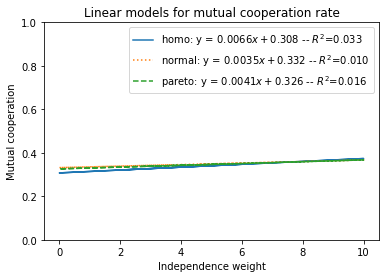

In [21]:
plt.figure()
plt.title("Linear models for mutual cooperation rate")

for distribution, linestyle in zip(("homo", "normal", "pareto"), ("solid", "dotted", "dashed")):
    data=df[df["mass_distribution"] == distribution]
    x, y = data["independence_weight"], data["mutual_cooperation"]
    slope, intercept, r, p, se = scipy.stats.linregress(x, y)
    plt.plot(x, slope * x + intercept, label=f"{distribution}: y = ${slope:.4f} x + {intercept:.3f}$ -- $R^2$={r ** 2:.3f}", linestyle=linestyle)
    
plt.ylim(0, 1)
plt.xlabel("Independence weight")
plt.ylabel("Mutual cooperation")
plt.legend()
plt.savefig("linear_models_for_mutual_cooperation_rate.pdf")

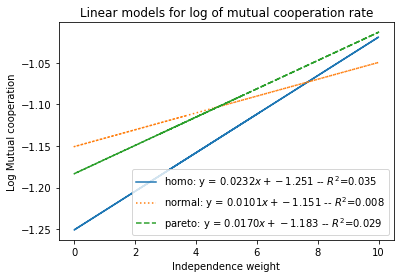

In [22]:
plt.figure()
plt.title("Linear models for log of mutual cooperation rate")

for distribution, linestyle in zip(("homo", "normal", "pareto"), ("solid", "dotted", "dashed")):
    data=df[df["mass_distribution"] == distribution]
    x, y = data["independence_weight"], data["log(mutual_cooperation)"]
    slope, intercept, r, p, se = scipy.stats.linregress(x, y)
    plt.plot(x, slope * x + intercept, label=f"{distribution}: y = ${slope:.4f} x + {intercept:.3f}$ -- $R^2$={r ** 2:.3f}", linestyle=linestyle)
    
plt.xlabel("Independence weight")
plt.ylabel("Log Mutual cooperation")
plt.legend()
plt.savefig("linear_models_for_log_mutual_cooperation_rate.pdf")

## Cooperation rate

Let us repeat the above analysis to consider the cooperation rate and not the mutual cooperation rate.

### Homogeneous:

In [23]:
results = smf.ols(
    "cooperation ~ independence_weight", 
    data=df[df["mass_distribution"] == "homo"],
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cooperation   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     91.56
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           2.37e-21
Time:                        13:43:32   Log-Likelihood:                 2233.4
No. Observations:                2675   AIC:                            -4463.
Df Residuals:                    2673   BIC:                            -4451.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4891      0.004    123.994      0.000       0.481       0.497
independence_weight     0.0067      0.001      9.569      0.000       0.005       0.008
==============================================================================
Omnibus:                       68.650   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.246
Skew:                          -0.288   Prob(JB):                     3.71e-13
Kurtosis:                       2.572   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Log transform of mutual cooperation:

In [24]:
results = smf.ols(
    "np.log(cooperation) ~ independence_weight", 
    data=df[df["mass_distribution"] == "homo"],
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(cooperation)   R-squared:                       0.034
Model:                             OLS   Adj. R-squared:                  0.034
Method:                  Least Squares   F-statistic:                     94.98
Date:                 Wed, 23 Nov 2022   Prob (F-statistic):           4.46e-22
Time:                         13:43:32   Log-Likelihood:                 265.03
No. Observations:                 2675   AIC:                            -526.1
Df Residuals:                     2673   BIC:                            -514.3
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.7433      0.008    -90.277      0.000      -0.759      -0.727
independence_weight     0.0142      0.001      9.746      0.000       0.011       0.017
==============================================================================
Omnibus:                      248.229   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.343
Skew:                          -0.816   Prob(JB):                     4.52e-70
Kurtosis:                       3.449   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Normal:

In [25]:
results = smf.ols(
    "np.log(cooperation) ~ independence_weight", 
    data=df[df["mass_distribution"] == "normal"],
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(cooperation)   R-squared:                       0.011
Model:                             OLS   Adj. R-squared:                  0.011
Method:                  Least Squares   F-statistic:                     29.97
Date:                 Wed, 23 Nov 2022   Prob (F-statistic):           4.78e-08
Time:                         13:43:32   Log-Likelihood:                 494.36
No. Observations:                 2675   AIC:                            -984.7
Df Residuals:                     2673   BIC:                            -972.9
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.6835      0.008    -90.454      0.000      -0.698      -0.669
independence_weight     0.0073      0.001      5.475      0.000       0.005       0.010
==============================================================================
Omnibus:                      370.683   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              569.115
Skew:                          -0.975   Prob(JB):                    2.62e-124
Kurtosis:                       4.143   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Log transform of mutual cooperation:

In [26]:
results = smf.ols(
    "cooperation ~ independence_weight", 
    data=df[df["mass_distribution"] == "normal"],
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cooperation   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     34.48
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           4.84e-09
Time:                        13:43:33   Log-Likelihood:                 2405.5
No. Observations:                2675   AIC:                            -4807.
Df Residuals:                    2673   BIC:                            -4795.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5146      0.004    139.123      0.000       0.507       0.522
independence_weight     0.0038      0.001      5.872      0.000       0.003       0.005
==============================================================================
Omnibus:                       85.800   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.244
Skew:                          -0.426   Prob(JB):                     4.18e-20
Kurtosis:                       2.726   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Pareto:

In [27]:
results = smf.ols(
    "cooperation ~ independence_weight", 
    data=df[df["mass_distribution"] == "pareto"],
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cooperation   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     49.99
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           1.96e-12
Time:                        13:43:33   Log-Likelihood:                 2606.6
No. Observations:                2675   AIC:                            -5209.
Df Residuals:                    2673   BIC:                            -5197.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5092      0.003    148.430      0.000       0.503       0.516
independence_weight     0.0043      0.001      7.071      0.000       0.003       0.005
==============================================================================
Omnibus:                       73.995   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.159
Skew:                           0.126   Prob(JB):                     1.15e-09
Kurtosis:                       2.447   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Log transform

In [28]:
results = smf.ols(
    "np.log(cooperation) ~ independence_weight", 
    data=df[df["mass_distribution"] == "pareto"],
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(cooperation)   R-squared:                       0.026
Model:                             OLS   Adj. R-squared:                  0.026
Method:                  Least Squares   F-statistic:                     72.17
Date:                 Wed, 23 Nov 2022   Prob (F-statistic):           3.23e-17
Time:                         13:43:33   Log-Likelihood:                 817.26
No. Observations:                 2675   AIC:                            -1631.
Df Residuals:                     2673   BIC:                            -1619.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.6994      0.007   -104.426      0.000      -0.713      -0.686
independence_weight     0.0100      0.001      8.495      0.000       0.008       0.012
==============================================================================
Omnibus:                       99.473   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.249
Skew:                          -0.408   Prob(JB):                     6.35e-28
Kurtosis:                       3.676   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**We do not see any big different effect.**

Here are plots that summarises all this:

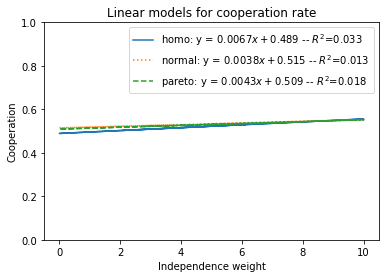

In [29]:
plt.figure()
plt.title("Linear models for cooperation rate")

for distribution, linestyle in zip(("homo", "normal", "pareto"), ("solid", "dotted", "dashed")):
    data=df[df["mass_distribution"] == distribution]
    x, y = data["independence_weight"], data["cooperation"]
    slope, intercept, r, p, se = scipy.stats.linregress(x, y)
    plt.plot(x, slope * x + intercept, label=f"{distribution}: y = ${slope:.4f} x + {intercept:.3f}$ -- $R^2$={r ** 2:.3f}", linestyle=linestyle)
    
plt.ylim(0, 1)
plt.xlabel("Independence weight")
plt.ylabel("Cooperation")
plt.legend()
plt.savefig("linear_models_for_cooperation_rate.pdf")

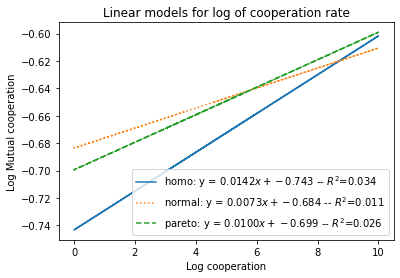

In [30]:
plt.figure()
plt.title("Linear models for log of cooperation rate")

for distribution, linestyle in zip(("homo", "normal", "pareto"), ("solid", "dotted", "dashed")):
    data=df[df["mass_distribution"] == distribution]
    x, y = data["independence_weight"], data["log(cooperation)"]
    slope, intercept, r, p, se = scipy.stats.linregress(x, y)
    plt.plot(x, slope * x + intercept, label=f"{distribution}: y = ${slope:.4f} x + {intercept:.3f}$ -- $R^2$={r ** 2:.3f}", linestyle=linestyle)
    
plt.xlabel("Log cooperation")
plt.ylabel("Log Mutual cooperation")
plt.legend()
plt.savefig("linear_models_for_log_of_cooperation_rate.pdf")

## Analysis of variance

Let us consider if there is a genuine difference between the distributions: note this won't look at the effect of the independence weight but will confirm if the distributions are different. So this answers the question:

> Is the mutual cooperation rate different in each distribution.

In [31]:
df.groupby("mass_distribution").describe()["mutual_cooperation"]

,count,mean,std,min,25%,50%,75%,max
mass_distribution,,,,,,,,
homo,2675.0,0.339771,0.107027,0.057383,0.265584,0.340584,0.423833,0.576728
normal,2675.0,0.349031,0.100174,0.064006,0.269773,0.354401,0.425456,0.587981
pareto,2675.0,0.346234,0.094809,0.063086,0.276462,0.330718,0.416346,0.559898


In [32]:
distributions, series = zip(*df.groupby("mass_distribution")["mutual_cooperation"])
f_val, p_val = stats.f_oneway(*series)
p_val

0.0026433069447801207

There is a significant difference between the 3 distributions.

In [33]:
distributions

('homo', 'normal', 'pareto')

We can see if there are pairwise differences:

Difference between homogenous and normal:

In [34]:
f_val, p_val = stats.f_oneway(*series[:-1])
p_val

0.001092681167137042

Is significant at the 0.05 level.

Different between normal and pareto:

In [35]:
f_val, p_val = stats.f_oneway(*series[0:])
p_val

0.0026433069447801207

Is significant at the 0.05 level.

Difference between homogenous and pareto:

In [36]:
f_val, p_val = stats.f_oneway(series[0], series[-1])
p_val

0.01941827043714653

Is significant at the 0.05 level.

## Conclusion

The independence weight has a significant but small effect on emergent mutual cooperation.

There is a small but significant effect on the distribution on mutual cooperation with a normal distribution leading to the highest level of mutual cooperation and homogeneous the lowest.